In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white", context="talk")
pd.set_option('display.max_columns', 500)

from keplergl import KeplerGl
from haversine import haversine, Unit



from datetime import datetime
from datetime import timedelta
import math
import random
import timeit

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import StandardScaler





In [4]:
def read_data(city_name):
    trip_data = pd.read_csv("Project_Data/Combined_Data/"+city_name+".csv", encoding = "ISO-8859-1")
    trip_data["trip_duration"] = pd.to_timedelta(trip_data["trip_duration"])
    trip_data["datetime_start"] = pd.to_datetime(trip_data["datetime_start"])
    trip_data["datetime_end"] = pd.to_datetime(trip_data["datetime_end"])
    trip_data["day"] = pd.to_datetime(trip_data["day"])


    return trip_data




In [5]:
kepler = read_data("duesseldorf")
test = pd.DataFrame(kepler.groupby(kepler["b_number"])["day"].count())
test = test.rename(columns={"day": "#rentals"})
kepler = pd.merge(kepler, test , on="b_number", how='left')
kepler.drop("trip_duration",inplace=True, axis=1)

kepler = kepler[kepler["#rentals"]>50]

bike_list = kepler["b_number"].unique()
radom_sample = random.choice(bike_list)

kepler = kepler[kepler["b_number"]== radom_sample]
kepler = kepler.sort_values(by=["datetime_start"])


kepler.head()



,Unnamed: 0,day,time,b_number,city,orig_lat,orig_lng,dest_lat,dest_lng,datetime_start,datetime_end,weekday,month,hour,week,distance,trip_duration_hours,avg_speed,rounded_time_hourly,temp,wind,rain,fleetsize_weekly,fleetsize_monthly,fleetsize_dayly,#rentals
8182,8182,2019-03-22,07:07:00,31333,duesseldorf,51.248546,6.776987,51.241685,6.737639,2019-03-22 07:07:00,2019-03-22 07:41:00,4,3,7,12,2.843151,0.566667,5.017326,2019-03-22 07:00:00,4.1,0.7,0.0,120,235,38,61
8183,8183,2019-03-22,15:55:00,31333,duesseldorf,51.241685,6.737639,51.224431,6.769757,2019-03-22 15:55:00,2019-03-22 16:22:00,4,3,15,12,2.946467,0.450000,6.547705,2019-03-22 16:00:00,20.2,4.2,0.0,120,235,38,61
8184,8184,2019-03-25,20:11:00,31333,duesseldorf,51.224431,6.769760,51.224222,6.769727,2019-03-25 20:11:00,2019-03-25 22:13:00,0,3,20,13,0.023343,2.033333,0.011480,2019-03-25 20:00:00,7.7,6.5,0.0,164,235,15,61
8185,8185,2019-03-26,10:56:00,31333,duesseldorf,51.224244,6.769941,51.225146,6.776751,2019-03-26 10:56:00,2019-03-26 11:58:00,1,3,10,13,0.484765,1.033333,0.469127,2019-03-26 11:00:00,7.7,4.8,0.0,164,235,21,61
8186,8186,2019-03-26,16:27:00,31333,duesseldorf,51.225146,6.776751,51.247284,6.794717,2019-03-26 16:27:00,2019-03-26 17:24:00,1,3,16,13,2.761173,0.950000,2.906498,2019-03-26 16:00:00,8.9,4.3,0.0,164,235,21,61


In [5]:

rebalancing_trip = kepler
rebalancing_trip = rebalancing_trip.sort_values(by=["datetime_start"])
rebalancing_trip["orig_lat"] = rebalancing_trip["orig_lat"].round(2)
rebalancing_trip["orig_lng"] = rebalancing_trip["orig_lng"].round(2)
rebalancing_trip["dest_lat"] = rebalancing_trip["dest_lat"].round(2)
rebalancing_trip["dest_lng"] = rebalancing_trip["dest_lng"].round(2)

rebalancing_trip = rebalancing_trip[(rebalancing_trip["dest_lat"].shift(1) != rebalancing_trip["orig_lat"])]  

rebalancing_trip

,Unnamed: 0,day,time,b_number,city,orig_lat,orig_lng,dest_lat,dest_lng,datetime_start,...,trip_duration_hours,avg_speed,rounded_time_hourly,temp,wind,rain,fleetsize_weekly,fleetsize_monthly,fleetsize_dayly,#rentals
11739,11739,2019-05-12,16:21:00,31862,duesseldorf,51.23,6.78,51.23,6.75,2019-05-12 16:21:00,...,0.200000,9.636711,2019-05-12 16:00:00,13.2,4.5,0.0,185,337,53,59
11747,11747,2019-05-24,22:54:00,31862,duesseldorf,51.23,6.81,51.23,6.79,2019-05-24 22:54:00,...,0.183333,10.580273,2019-05-24 23:00:00,12.4,2.5,0.0,244,337,91,59
11748,11748,2019-05-31,07:16:00,31862,duesseldorf,51.22,6.78,51.23,6.77,2019-05-31 07:16:00,...,1.250000,0.852747,2019-05-31 07:00:00,17.2,4.5,0.0,256,337,114,59


In [118]:
kepler =read_data("duesseldorf")
kepler["orig_lat"] = kepler["orig_lat"].round(2)
kepler["orig_lng"] = kepler["orig_lng"].round(2)
car2go_E_charging_map = KeplerGl(height=1000)
car2go_E_charging_map.add_data(data=kepler.drop("trip_duration",axis=1),name='duesseldorf')
car2go_E_charging_map


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'duesseldorf': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,…

In [117]:
kepler =read_data("bremen")

car2go_E_charging_map = KeplerGl(height=1000)
car2go_E_charging_map.add_data(data=kepler.drop("trip_duration",axis=1),name='bremen')
car2go_E_charging_map



User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'bremen': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, …

In [7]:
from sklearn.preprocessing import PolynomialFeatures

In [19]:
def plot_Poly_regression(X,Y,d):
    from sklearn.model_selection import train_test_split


    poly_reg = PolynomialFeatures (degree = d)
    
    # Polynomial transformation
    x_poly = poly_reg.fit_transform(X.reshape(-1,1))
    lin_reg_Poly = LinearRegression()
    
    # hold out set
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=42)


    
    
    # Fitting linear regression to polynomial features
    lin_reg_Poly.fit(x_poly, Y)
    model_pred = lin_reg_Poly.predict(x_poly)
    
    # Plotting the regression line and the data
    x_fit = np.arange(X.min(),X.max() ,1)[:, np.newaxis]
    y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(x_fit.reshape(-1,1)))
    
    plt.scatter(X,Y,marker="x", c='C2')
    ylim = plt.ylim()
    
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([X.min()-2,X.max()+2])
    plt.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(Y, model_pred))
    print(lin_reg_Poly.coef_)

In [28]:
def lin_regression(X,Y):
    lr = LinearRegression()
    lr.fit(X.reshape(-1,1), Y)
    model_pred_p = lr.predict(X.reshape(-1,1))
    plt.scatter(X, Y, marker="x" )
    plt.xlabel("High Temperature (°C)")
    plt.ylabel("Peak Demand (GW)")
    plt.plot(X, model_pred_p, c='C2')
    print ('The R^2 of linear regression is: ',r2_score(Y, model_pred_p))

In [137]:
Test = read_data("duesseldorf")
Test.head(2)

,Unnamed: 0,day,time,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,datetime_start,datetime_end,weekday,month,hour,week,distance,trip_duration_hours,avg_speed,rounded_time_hourly,temp,wind,rain,fleetsize_weekly,fleetsize_monthly,fleetsize_dayly
0,0,2019-02-06,15:35:00,538,duesseldorf,0 days 00:17:00,51.218927,6.765862,51.240644,6.781982,2019-02-06 15:35:00,2019-02-06 15:52:00,2,2,15,6,2.662958,0.283333,9.398675,2019-02-06 16:00:00,9.5,5.0,0.0,51,131,15
1,1,2019-02-19,15:57:00,538,duesseldorf,0 days 00:23:00,51.213766,6.751624,51.223056,6.779230,2019-02-19 15:57:00,2019-02-19 16:20:00,1,2,15,8,2.182598,0.383333,5.693734,2019-02-19 16:00:00,10.3,5.6,0.0,69,131,16


In [96]:

def set_dataset_absolute(data, X_column, group_by):
    weather = pd.DataFrame()
    weather[X_column] = data.groupby(group_by)[X_column].mean()
    weather["number_ids"]= data.groupby(group_by)["b_number"].count()
    return weather

test = set_dataset_absolute(Test, "temp", "day")

The R^2 of linear regression is:  0.6879473425021476


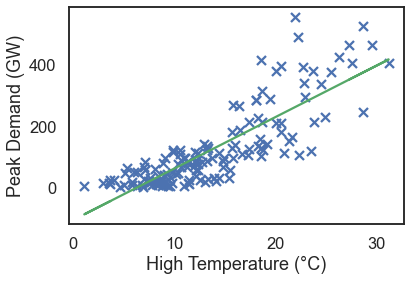

In [37]:
lin_regression(test["temp"].values,test["number_ids"].values)

In [115]:
from haversine import haversine, Unit


def distance_between_coordinates (trip_data, city_center_lat,city_center_lng):
    trip_data["distance_from_center_start"] = trip_data.apply(lambda row: haversine((row["orig_lat"], row["orig_lng"]),(city_center_lat, city_center_lng),Unit.KILOMETERS), axis=1) 
   #X = trip_data.drop(["day","time","b_number","city","trip_duration","orig_lat","orig_lng","dest_lat","dest_lng","avg_speed","rounded_time_hourly","temp","wind","rain","fleetsize_weekly","fleetsize_monthly","fleetsize_dayly","Unnamed: 0","datetime_start","datetime_end","weekday","month","hour","week"], axis=1)
#    X.drop(["distance"],axis=1,inplace=True)
    return trip_data   

In [168]:
test2 = distance_between_coordinates(Test, 51.216429, 6.791910)

In [169]:
test2["distance_from_center_start"] = test2["distance_from_center_start"].apply(np.ceil)

The R^2 for quadratic curve is:  0.7437151142778206
[    0.         -1171.27554113    47.52922078]


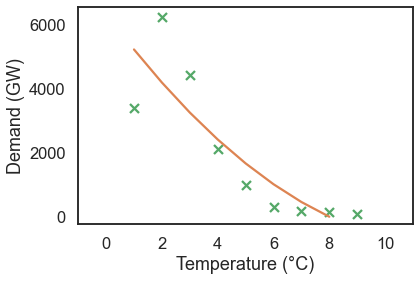

In [170]:
test3 = set_dataset_absolute(test2, "distance_from_center_start", "distance_from_center_start" )
test3 = test3[test3["distance_from_center_start"]<10]

plot_Poly_regression(test3["distance_from_center_start"].values,test3["number_ids"].values,2)

In [121]:


plot_Poly_regression(test["temp"].values,test["number_ids"].values,4)

NameError: name 'plot_Poly_regression' is not defined

,Unnamed: 0,b_number,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,weekday,month,hour,week,distance,trip_duration_hours,avg_speed,temp,wind,rain,fleetsize_weekly,fleetsize_monthly,fleetsize_dayly,distance_from_center_start
count,18038.000000,18038.000000,18038,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000
mean,9018.500000,30615.641091,0 days 00:27:17.556270096,51.225214,6.784543,51.225157,6.784426,3.204734,5.218539,13.373157,21.263555,1.717273,0.454877,5.773809,19.108926,3.954829,0.027692,341.238275,497.056104,135.391063,2.717929
std,5207.266413,6909.397025,0 days 00:32:11.834626498,0.022536,0.023901,0.022143,0.023038,1.986495,1.068599,5.058998,4.771807,1.602547,0.536621,3.558801,7.026636,1.816669,0.311807,149.701612,188.230842,71.743387,2.257239
min,0.000000,538.000000,0 days 00:03:00,50.677853,6.180219,50.677916,6.644770,0.000000,2.000000,0.000000,5.000000,0.000918,0.050000,0.000927,-1.600000,0.300000,0.000000,21.000000,131.000000,3.000000,1.000000
25%,4509.250000,31252.000000,0 days 00:09:00,51.213752,6.775237,51.213752,6.774851,1.000000,5.000000,10.000000,18.000000,0.709099,0.150000,2.877966,14.000000,2.600000,0.000000,205.000000,337.000000,72.000000,2.000000
50%,9018.500000,31359.000000,0 days 00:16:00,51.223149,6.784169,51.223311,6.784123,3.000000,6.000000,14.000000,23.000000,1.378615,0.266667,5.997485,19.300000,3.800000,0.000000,330.000000,659.000000,127.000000,2.000000
75%,13527.750000,31932.000000,0 days 00:28:00,51.236648,6.794867,51.236648,6.794867,5.000000,6.000000,17.000000,25.000000,2.322811,0.466667,8.387293,24.500000,5.100000,0.000000,501.000000,659.000000,201.000000,3.000000
max,18037.000000,53159.000000,0 days 02:59:00,51.523058,7.480777,51.523396,7.480644,6.000000,6.000000,23.000000,26.000000,43.457380,2.983333,24.703928,36.100000,17.600000,8.200000,538.000000,659.000000,257.000000,66.000000


In [1]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


agglo = AgglomerativeClustering(n_clusters=3)
y_pred_agglo = agglo.fit_predict(X_scaled)

plt.figure(figsize=(15,10))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(agglo, labels=agglo.labels_)
plt.ylabel("Distance")
plt.show()

NameError: name 'X_scaled' is not defined

In [83]:
density = read_data("duesseldorf")


In [84]:

density["orig_coordinate"] = list(zip(density["orig_lat"].round(2),density["orig_lng"].round(2)))

In [87]:
desitiy_orig = density.groupby("orig_coordinate").count()

In [91]:
desitiy_orig.sort_values("b_number").reset_index()["b_number"]

0         1
1         1
2         1
3         1
4         1
       ... 
188     932
189     934
190     990
191    1043
192    1232
Name: b_number, Length: 193, dtype: int64

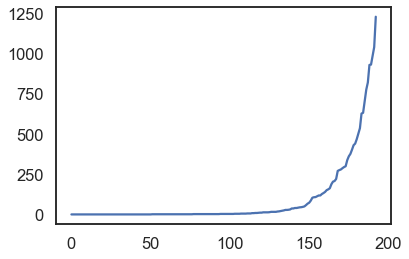

In [92]:
y = desitiy_orig.sort_values("b_number").reset_index()["b_number"]
x = desitiy_orig.sort_values("b_number").reset_index()["b_number"].index
plt.plot(x,y)
plt.show()    

In [114]:
desitiy_orig[desitiy_orig["b_number"]>550].sum()

Unnamed: 0             8700
day                    8700
time                   8700
b_number               8700
city                   8700
trip_duration          8700
orig_lat               8700
orig_lng               8700
dest_lat               8700
dest_lng               8700
datetime_start         8700
datetime_end           8700
weekday                8700
month                  8700
hour                   8700
week                   8700
distance               8700
trip_duration_hours    8700
avg_speed              8700
rounded_time_hourly    8700
temp                   8700
wind                   8700
rain                   8700
fleetsize_weekly       8700
fleetsize_monthly      8700
fleetsize_dayly        8700
dtype: int64

In [113]:
desitiy_orig[desitiy_orig["b_number"]<550].sum()

Unnamed: 0             9338
day                    9338
time                   9338
b_number               9338
city                   9338
trip_duration          9338
orig_lat               9338
orig_lng               9338
dest_lat               9338
dest_lng               9338
datetime_start         9338
datetime_end           9338
weekday                9338
month                  9338
hour                   9338
week                   9338
distance               9338
trip_duration_hours    9338
avg_speed              9338
rounded_time_hourly    9338
temp                   9338
wind                   9338
rain                   9338
fleetsize_weekly       9338
fleetsize_monthly      9338
fleetsize_dayly        9338
dtype: int64

In [107]:
desitiy_orig[desitiy_orig["b_number"]>550]

,Unnamed: 0,day,time,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,datetime_start,datetime_end,weekday,month,hour,week,distance,trip_duration_hours,avg_speed,rounded_time_hourly,temp,wind,rain,fleetsize_weekly,fleetsize_monthly,fleetsize_dayly
orig_coordinate,,,,,,,,,,,,,,,,,,,,,,,,,,
"(51.21, 6.78)",990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990
"(51.21, 6.79)",934,934,934,934,934,934,934,934,934,934,934,934,934,934,934,934,934,934,934,934,934,934,934,934,934,934
"(51.22, 6.77)",778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778
"(51.22, 6.78)",1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043
"(51.22, 6.79)",1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232
"(51.22, 6.8)",629,629,629,629,629,629,629,629,629,629,629,629,629,629,629,629,629,629,629,629,629,629,629,629,629,629
"(51.23, 6.78)",932,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932
"(51.24, 6.78)",823,823,823,823,823,823,823,823,823,823,823,823,823,823,823,823,823,823,823,823,823,823,823,823,823,823
"(51.24, 6.79)",705,705,705,705,705,705,705,705,705,705,705,705,705,705,705,705,705,705,705,705,705,705,705,705,705,705


Unnamed: 0             18038
day                    18038
time                   18038
b_number               18038
city                   18038
trip_duration          18038
orig_lat               18038
orig_lng               18038
dest_lat               18038
dest_lng               18038
datetime_start         18038
datetime_end           18038
weekday                18038
month                  18038
hour                   18038
week                   18038
distance               18038
trip_duration_hours    18038
avg_speed              18038
rounded_time_hourly    18038
temp                   18038
wind                   18038
rain                   18038
fleetsize_weekly       18038
fleetsize_monthly      18038
fleetsize_dayly        18038
orig_coordinate        18038
dtype: int64